<a href="https://colab.research.google.com/github/maryvorob/colab/blob/master/sobaka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import differential_evolution
from matplotlib import colors
import numpy as np
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [7, 3]


def diff_month(d1, d2):
    # https://stackoverflow.com/questions/4039879/best-way-to-find-the-months-between-two-dates
    return (d1.year - d2.year) * 12 + d1.month - d2.month


def background_gradient(s, m=0, M=0.4, cmap='Wistia', low=0, high=1):
    # https://stackoverflow.com/questions/38931566/pandas-style-background-gradient-both-rows-and-columns
    rng = M - m
    normed = colors.Normalize(m - (rng * low), M + (rng * high))(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

# Orders

In [2]:
url = 'https://github.com/maryvorob/colab/blob/master/sobaka.xlsx?raw=true'
data = pd.read_excel(url, usecols=[0, 1, 2])
data.columns = ['ts', 'client_id', 'price']
data['ts'] = pd.to_datetime(data['ts'])
data['month'] = data['ts'].astype('<M8[M]')
data['day'] = data['ts'].astype('<M8[D]')
data.head()

,ts,client_id,price,month,day
0,2018-01-31 22:30:00,1,500,2018-01-01,2018-01-31
1,2018-01-31 22:00:00,2,500,2018-01-01,2018-01-31
2,2018-01-31 21:00:00,3,500,2018-01-01,2018-01-31
3,2018-01-31 21:00:00,4,500,2018-01-01,2018-01-31
4,2018-01-31 20:30:00,5,500,2018-01-01,2018-01-31


# New Users

,ts,day,month
client_id,,,
1,2017-12-15 22:30:00,2017-12-15,2017-12-01
2,2017-12-12 12:00:00,2017-12-12,2017-12-01
3,2016-11-27 11:00:00,2016-11-27,2016-11-01
4,2017-12-24 21:00:00,2017-12-24,2017-12-01
5,2018-01-24 20:30:00,2018-01-24,2018-01-01


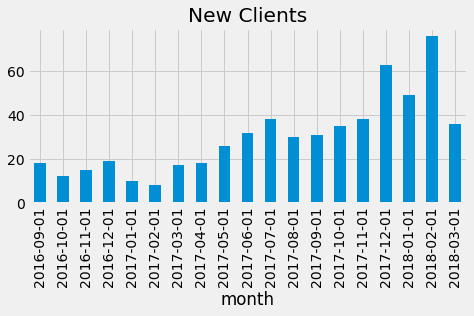

In [66]:
users = data.groupby('client_id')[['ts', 'day', 'month']].min()
users.groupby(users['month'].astype(str)).size().plot(kind='bar', rot=90, title='New Clients')
users.head()

# Active Users

,month,client_id,orders,rev,birth,age,status
0,2016-09-01,14,12,6000,2016-09-01,0,NEW
1,2016-09-01,26,36,18000,2016-09-01,0,NEW
2,2016-09-01,41,14,7000,2016-09-01,0,NEW
3,2016-09-01,73,11,5500,2016-09-01,0,NEW
4,2016-09-01,228,2,1000,2016-09-01,0,NEW


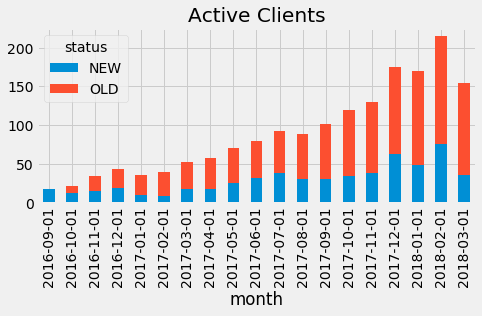

In [67]:
au = data.groupby(['month', 'client_id']).agg(orders=('price', 'count'), rev=('price', 'sum')).reset_index()
au['birth'] = au['client_id'].map(users['month'])
au['age'] = diff_month(df['month'].dt, df['birth'].dt)
au['status'] = (au['age'] == 0).map({False: 'OLD', True: 'NEW'})
au.groupby([au['month'].astype(str), 'status']).size().unstack('status').plot(kind='bar', rot=90, stacked=True, title='Active Clients');
au.head()

# Cohorts

In [71]:
coh = au.groupby([au['birth'].astype(str), 'age'])['rev'].agg(users='count', rev='sum').unstack('birth')
coh['users'].fillna(0).style.apply(background_gradient, low=0, high=50)

birth,2016-09-01,2016-10-01,2016-11-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01
age,,,,,,,,,,,,,,,,,,,
0,18,12,15,19,10,8,17,18,26,32,38,30,31,35,38,63,49,76,36
1,9,9,7,10,4,6,8,8,6,17,14,14,16,17,21,36,25,26,0
2,10,6,3,5,1,6,6,5,6,11,12,10,13,17,18,23,13,0,0
3,11,5,7,4,1,6,8,5,7,8,7,10,11,10,15,17,0,0,0
4,8,6,9,4,1,5,4,3,7,9,8,9,10,10,10,0,0,0,0
5,10,5,5,4,2,4,5,4,7,7,8,6,12,5,0,0,0,0,0
6,10,6,6,2,1,4,4,5,6,6,7,5,9,0,0,0,0,0,0
7,9,6,6,2,1,5,5,5,7,5,8,5,0,0,0,0,0,0,0
8,8,4,4,1,1,5,4,3,4,3,8,0,0,0,0,0,0,0,0


# Retention

birth,2016-09-01,2016-10-01,2016-11-01,2016-12-01,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01
age,,,,,,,,,,,,,,,,,,,
0,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%,100.0%
1,50.0%,75.0%,46.7%,52.6%,40.0%,75.0%,47.1%,44.4%,23.1%,53.1%,36.8%,46.7%,51.6%,48.6%,55.3%,57.1%,51.0%,34.2%,0.0%
2,55.6%,50.0%,20.0%,26.3%,10.0%,75.0%,35.3%,27.8%,23.1%,34.4%,31.6%,33.3%,41.9%,48.6%,47.4%,36.5%,26.5%,0.0%,0.0%
3,61.1%,41.7%,46.7%,21.1%,10.0%,75.0%,47.1%,27.8%,26.9%,25.0%,18.4%,33.3%,35.5%,28.6%,39.5%,27.0%,0.0%,0.0%,0.0%
4,44.4%,50.0%,60.0%,21.1%,10.0%,62.5%,23.5%,16.7%,26.9%,28.1%,21.1%,30.0%,32.3%,28.6%,26.3%,0.0%,0.0%,0.0%,0.0%
5,55.6%,41.7%,33.3%,21.1%,20.0%,50.0%,29.4%,22.2%,26.9%,21.9%,21.1%,20.0%,38.7%,14.3%,0.0%,0.0%,0.0%,0.0%,0.0%
6,55.6%,50.0%,40.0%,10.5%,10.0%,50.0%,23.5%,27.8%,23.1%,18.8%,18.4%,16.7%,29.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
7,50.0%,50.0%,40.0%,10.5%,10.0%,62.5%,29.4%,27.8%,26.9%,15.6%,21.1%,16.7%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
8,44.4%,33.3%,26.7%,5.3%,10.0%,62.5%,23.5%,16.7%,15.4%,9.4%,21.1%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%


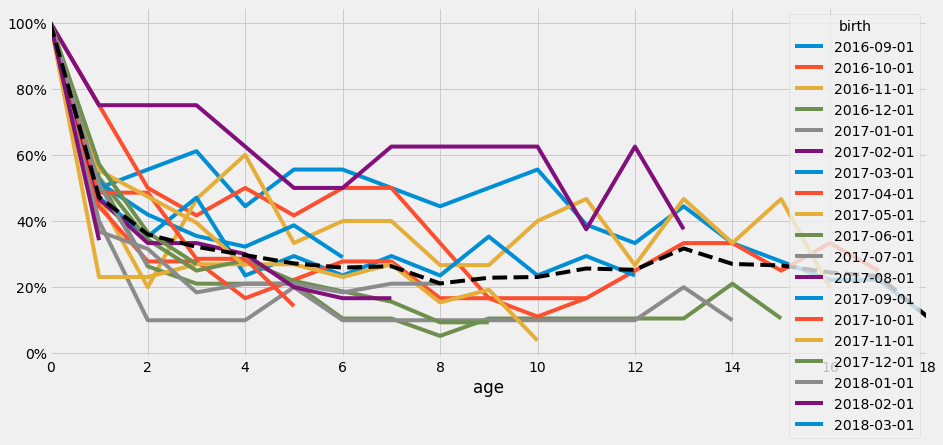

In [107]:
def actual_retention(coh, val='users'):
    df = coh[val].copy()
    df['num'] = df.sum(axis=1)
    df['den'] = df.values[0, :-1].cumsum()[::-1]
    df['ret'] = df['num'] / df['den']
    return df['ret']

ret = coh['users'].divide(coh['users'].loc[0])
act_ret = retention(coh)
ax = ret.plot(figsize=(14, 6));
# https://stackoverflow.com/questions/31357611/format-y-axis-as-percent
ax.set_yticklabels(['{:.0%}'.format(y) for y in ax.get_yticks()]);
ax.plot(act_ret, c='k', lw=4, ls='--');
ret.fillna(0).style.apply(background_gradient).format('{:.1%}')

In [0]:
def mre(y_true, y_pred):
    # mean relative error
    mask = y_true.nonzero()
    error = (y_true[mask] - y_pred[mask]) ** 2 / y_true[mask]
    return np.mean(np.abs(error))

def ret(pars, x=np.arange(18)):
    a, b, c = pars
    return a * np.exp(-b * x) + (1 - a) * np.exp(-c * x)

def y_true(coh):
    return coh['users'].fillna(0).values

def y_pred(pars, y_true):
    base = y_true[0][np.newaxis, :]
    x = np.arange(len(y_true))
    r = ret(pars, x).reshape(-1, 1)
    return r @ base * np.sign(y_true)

def loss(pars, y_true):
    return mre(y_true, y_pred(pars, y_true))

def fit(coh):
    bounds = [[0, 1], [0, 1], [0, 10]]
    model = differential_evolution(loss, bounds, args=(y_true(coh), ), popsize=100)
    return model.x

pars = fit(coh)

In [141]:
pd.DataFrame(y_true(coh)).style.apply(background_gradient, low=0, high=50).format('{:.1f}')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,18.0,12.0,15.0,19.0,10.0,8.0,17.0,18.0,26.0,32.0,38.0,30.0,31.0,35.0,38.0,63.0,49.0,76.0,36.0
1,9.0,9.0,7.0,10.0,4.0,6.0,8.0,8.0,6.0,17.0,14.0,14.0,16.0,17.0,21.0,36.0,25.0,26.0,0.0
2,10.0,6.0,3.0,5.0,1.0,6.0,6.0,5.0,6.0,11.0,12.0,10.0,13.0,17.0,18.0,23.0,13.0,0.0,0.0
3,11.0,5.0,7.0,4.0,1.0,6.0,8.0,5.0,7.0,8.0,7.0,10.0,11.0,10.0,15.0,17.0,0.0,0.0,0.0
4,8.0,6.0,9.0,4.0,1.0,5.0,4.0,3.0,7.0,9.0,8.0,9.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0
5,10.0,5.0,5.0,4.0,2.0,4.0,5.0,4.0,7.0,7.0,8.0,6.0,12.0,5.0,0.0,0.0,0.0,0.0,0.0
6,10.0,6.0,6.0,2.0,1.0,4.0,4.0,5.0,6.0,6.0,7.0,5.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0
7,9.0,6.0,6.0,2.0,1.0,5.0,5.0,5.0,7.0,5.0,8.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,8.0,4.0,4.0,1.0,1.0,5.0,4.0,3.0,4.0,3.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,9.0,2.0,4.0,2.0,1.0,5.0,6.0,3.0,5.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [140]:
pd.DataFrame(y_pred(pars, y_true(coh))).style.apply(background_gradient, low=0, high=50).format('{:.1f}')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,18.0,12.0,15.0,19.0,10.0,8.0,17.0,18.0,26.0,32.0,38.0,30.0,31.0,35.0,38.0,63.0,49.0,76.0,36.0
1,8.3,5.5,6.9,8.7,4.6,3.7,7.8,8.3,12.0,14.7,17.5,13.8,14.3,16.1,17.5,29.0,22.5,35.0,0.0
2,5.6,3.7,4.6,5.9,3.1,2.5,5.3,5.6,8.0,9.9,11.8,9.3,9.6,10.8,11.8,19.5,15.2,0.0,0.0
3,4.7,3.1,3.9,5.0,2.6,2.1,4.4,4.7,6.8,8.3,9.9,7.8,8.1,9.1,9.9,16.4,0.0,0.0,0.0
4,4.3,2.9,3.6,4.6,2.4,1.9,4.1,4.3,6.2,7.7,9.1,7.2,7.4,8.4,9.1,0.0,0.0,0.0,0.0
5,4.1,2.7,3.4,4.3,2.3,1.8,3.8,4.1,5.9,7.2,8.6,6.8,7.0,7.9,0.0,0.0,0.0,0.0,0.0
6,3.9,2.6,3.2,4.1,2.1,1.7,3.7,3.9,5.6,6.9,8.2,6.4,6.7,0.0,0.0,0.0,0.0,0.0,0.0
7,3.7,2.5,3.1,3.9,2.0,1.6,3.5,3.7,5.3,6.6,7.8,6.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,3.5,2.3,2.9,3.7,2.0,1.6,3.3,3.5,5.1,6.2,7.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,3.3,2.2,2.8,3.5,1.9,1.5,3.2,3.3,4.8,5.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


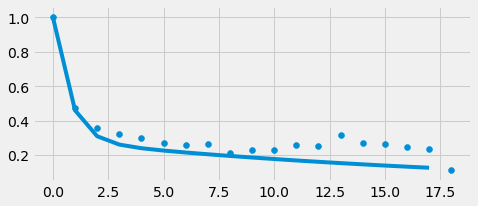

In [119]:
plt.scatter(act_ret.index, act_ret)
plt.plot(ret(pars))

In [106]:
retention(coh)

age
0     1.000000
1     0.472897
2     0.359477
3     0.321951
4     0.296830
5     0.271845
6     0.259124
7     0.263374
8     0.211268
9     0.228571
10    0.230769
11    0.256410
12    0.252525
13    0.317073
14    0.270270
15    0.265625
16    0.244444
17    0.233333
18    0.111111
Name: ret, dtype: float64